In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import h5py
import zindex.zindex as zz
import matplotlib.pyplot as plt

/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


z,x,y 1 0 0


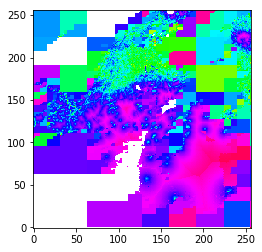

CPU times: user 434 ms, sys: 412 ms, total: 846 ms
Wall time: 1.56 s


In [163]:
%%time

import zindex.zindex as zz

def tile_data(z, x, y, width=1, height=1):
    '''
    Get interpolated values for a tile as defined by the 
    zoom level (z), x position (x), y position (y) and 
    '''
    tile_width = 360 / 2 ** z    
    tile_x = -180 + x * tile_width
    tile_y = 180 - (y + 1) * tile_width
    
    bounds = [tile_x, tile_y, 
              tile_x + tile_width, 
              tile_y + tile_width]
    
    f = h5py.File('../data/points.hdf5', 'r')
    tile_pixels = 256
    sorted_interleaved = f['interleaved']
    sorted_points = f['sorted_points'][:]
    sorted_poi = f['values'][:]
    
    (ixs, positions) = zz.interpolate(
        f['interleaved'],
        region_bounds=bounds,
        global_bounds=[-180,-180,180,180],
        width=256 * width, 
        height=256 * width
    )
    ixs[ixs == len(sorted_interleaved)] = len(sorted_interleaved) - 1
    
    residuals = ((positions - sorted_points[ixs]) ** 2).sum(axis=1)
    new_array = sorted_poi[ixs]
    # new_array[residuals > 2] = np.nan

    mat = new_array.reshape((tile_pixels,tile_pixels))
    
    return mat.T.copy(order='C')

mat = tile_data(1,0,0)
plt.imshow(np.log(mat), origin='lower', cmap='hsv')
plt.show()

In [164]:
def tileset_info():
    return {
        'min_pos': [-180, -180],
        'max_pos': [180, 180],
        'max_width': 360,
        'max_zoom': 8,
        'mirror_tiles': 'false'
    }

In [165]:
# f = lambda z,x,y: ((z,x,y), hgfo.format_dense_tile(tile_data(z, x, y)))
# f(0,0,0)

In [166]:
import hgflask.server as hgse
import hgflask.tilesets as hfti
import hgtiles.format as hgfo
import hgtiles.utils as hgut

ts = hfti.Tileset(
    tileset_info=tileset_info,
    tiles=lambda tile_ids: hgut.tiles_wrapper_2d(tile_ids,
                    lambda z,x,y: hgfo.format_dense_tile(tile_data(z, x, y)))
)

server = hgse.start([ts])

terminating: SMDFYwhtTHq4ObhL8qITZw
sleeping


 * Running on http://0.0.0.0:61751/ (Press CTRL+C to quit)


sleeping


127.0.0.1 - - [08/Nov/2018 18:02:55] "GET /api/v1/tileset_info/?d=a HTTP/1.1" 200 -


ret: 200 b'{\n  "a": {\n    "error": "No such tileset with uid: a"\n  }\n}\n'
returning
z,x,y 4 4 5


127.0.0.1 - - [08/Nov/2018 18:02:56] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.4.4.5 HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:02:58] "OPTIONS /api/v1/tileset_info/?d=dJhn8k4hTySVZz41uSgn7w&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:02:58] "GET /api/v1/tileset_info/?d=dJhn8k4hTySVZz41uSgn7w&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:02:59] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.3.4.4&d=dJhn8k4hTySVZz41uSgn7w.3.4.5&d=dJhn8k4hTySVZz41uSgn7w.3.5.4&d=dJhn8k4hTySVZz41uSgn7w.3.5.5&d=dJhn8k4hTySVZz41uSgn7w.3.6.4&d=dJhn8k4hTySVZz41uSgn7w.3.6.5&d=dJhn8k4hTySVZz41uSgn7w.1.0.0&d=dJhn8k4hTySVZz41uSgn7w.1.0.1&d=dJhn8k4hTySVZz41uSgn7w.1.1.0&d=dJhn8k4hTySVZz41uSgn7w.1.1.1&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 3 6 4
z,x,y 3 6 5
z,x,y 1 1 0
z,x,y 3 5 5
z,x,y 1 0 1
z,x,y 1 1 1
z,x,y 3 4 5
z,x,y 3 4 4
z,x,y 1 0 0
z,x,y 3 5 4


127.0.0.1 - - [08/Nov/2018 18:03:01] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.3.4.4&d=dJhn8k4hTySVZz41uSgn7w.3.4.5&d=dJhn8k4hTySVZz41uSgn7w.3.5.4&d=dJhn8k4hTySVZz41uSgn7w.3.5.5&d=dJhn8k4hTySVZz41uSgn7w.3.6.4&d=dJhn8k4hTySVZz41uSgn7w.3.6.5&d=dJhn8k4hTySVZz41uSgn7w.1.0.0&d=dJhn8k4hTySVZz41uSgn7w.1.0.1&d=dJhn8k4hTySVZz41uSgn7w.1.1.0&d=dJhn8k4hTySVZz41uSgn7w.1.1.1&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:03:04] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.2.0.0&d=dJhn8k4hTySVZz41uSgn7w.2.0.1&d=dJhn8k4hTySVZz41uSgn7w.2.0.2&d=dJhn8k4hTySVZz41uSgn7w.2.1.0&d=dJhn8k4hTySVZz41uSgn7w.2.1.1&d=dJhn8k4hTySVZz41uSgn7w.2.1.2&d=dJhn8k4hTySVZz41uSgn7w.2.2.0&d=dJhn8k4hTySVZz41uSgn7w.2.2.1&d=dJhn8k4hTySVZz41uSgn7w.2.2.2&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 2 1 1
z,x,y 2 2 0
z,x,y 2 1 0
z,x,y 2 0 2
z,x,y 2 0 1
z,x,y 2 2 2
z,x,y 2 1 2
z,x,y 2 0 0
z,x,y 2 2 1


127.0.0.1 - - [08/Nov/2018 18:03:06] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.2.0.0&d=dJhn8k4hTySVZz41uSgn7w.2.0.1&d=dJhn8k4hTySVZz41uSgn7w.2.0.2&d=dJhn8k4hTySVZz41uSgn7w.2.1.0&d=dJhn8k4hTySVZz41uSgn7w.2.1.1&d=dJhn8k4hTySVZz41uSgn7w.2.1.2&d=dJhn8k4hTySVZz41uSgn7w.2.2.0&d=dJhn8k4hTySVZz41uSgn7w.2.2.1&d=dJhn8k4hTySVZz41uSgn7w.2.2.2&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:03:11] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.4.3.5&d=dJhn8k4hTySVZz41uSgn7w.4.3.6&d=dJhn8k4hTySVZz41uSgn7w.4.4.5&d=dJhn8k4hTySVZz41uSgn7w.4.4.6&d=dJhn8k4hTySVZz41uSgn7w.4.5.5&d=dJhn8k4hTySVZz41uSgn7w.4.5.6&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 4 3 5
z,x,y 4 4 6
z,x,y 4 5 5
z,x,y 4 4 5
z,x,y 4 5 6
z,x,y 4 3 6


127.0.0.1 - - [08/Nov/2018 18:03:12] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.4.3.5&d=dJhn8k4hTySVZz41uSgn7w.4.3.6&d=dJhn8k4hTySVZz41uSgn7w.4.4.5&d=dJhn8k4hTySVZz41uSgn7w.4.4.6&d=dJhn8k4hTySVZz41uSgn7w.4.5.5&d=dJhn8k4hTySVZz41uSgn7w.4.5.6&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:03:15] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.6.16.23&d=dJhn8k4hTySVZz41uSgn7w.6.16.24&d=dJhn8k4hTySVZz41uSgn7w.6.17.23&d=dJhn8k4hTySVZz41uSgn7w.6.17.24&d=dJhn8k4hTySVZz41uSgn7w.6.18.23&d=dJhn8k4hTySVZz41uSgn7w.6.18.24&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 6 18 24
z,x,y 6 17 24
z,x,y 6 16 23
z,x,y 6 17 23
z,x,y 6 18 23
z,x,y 6 16 24


127.0.0.1 - - [08/Nov/2018 18:03:16] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.6.16.23&d=dJhn8k4hTySVZz41uSgn7w.6.16.24&d=dJhn8k4hTySVZz41uSgn7w.6.17.23&d=dJhn8k4hTySVZz41uSgn7w.6.17.24&d=dJhn8k4hTySVZz41uSgn7w.6.18.23&d=dJhn8k4hTySVZz41uSgn7w.6.18.24&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:03:20] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.6.16.25&d=dJhn8k4hTySVZz41uSgn7w.6.17.25&d=dJhn8k4hTySVZz41uSgn7w.6.18.25&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 6 16 25
z,x,y 6 17 25


127.0.0.1 - - [08/Nov/2018 18:03:21] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.5.7.11&d=dJhn8k4hTySVZz41uSgn7w.5.7.12&d=dJhn8k4hTySVZz41uSgn7w.5.7.13&d=dJhn8k4hTySVZz41uSgn7w.5.8.11&d=dJhn8k4hTySVZz41uSgn7w.5.8.12&d=dJhn8k4hTySVZz41uSgn7w.5.8.13&d=dJhn8k4hTySVZz41uSgn7w.5.9.11&d=dJhn8k4hTySVZz41uSgn7w.5.9.12&d=dJhn8k4hTySVZz41uSgn7w.5.9.13&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 5 7 13
z,x,y 6 18 25


127.0.0.1 - - [08/Nov/2018 18:03:21] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.6.16.25&d=dJhn8k4hTySVZz41uSgn7w.6.17.25&d=dJhn8k4hTySVZz41uSgn7w.6.18.25&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 5 8 12
z,x,y 5 8 13


127.0.0.1 - - [08/Nov/2018 18:03:22] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.4.3.5&d=dJhn8k4hTySVZz41uSgn7w.4.3.6&d=dJhn8k4hTySVZz41uSgn7w.4.3.7&d=dJhn8k4hTySVZz41uSgn7w.4.4.5&d=dJhn8k4hTySVZz41uSgn7w.4.4.6&d=dJhn8k4hTySVZz41uSgn7w.4.4.7&d=dJhn8k4hTySVZz41uSgn7w.4.5.5&d=dJhn8k4hTySVZz41uSgn7w.4.5.6&d=dJhn8k4hTySVZz41uSgn7w.4.5.7&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 4 3 5
z,x,y 5 8 11
z,x,y 4 4 6
z,x,y 5 7 11
z,x,y 4 5 5
z,x,y 5 9 11
z,x,y 4 4 5
z,x,y 5 9 13
z,x,y 4 3 7
z,x,y 5 7 12
z,x,y 4 4 7
z,x,y 5 9 12
z,x,y 4 5 6


127.0.0.1 - - [08/Nov/2018 18:03:24] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.5.7.11&d=dJhn8k4hTySVZz41uSgn7w.5.7.12&d=dJhn8k4hTySVZz41uSgn7w.5.7.13&d=dJhn8k4hTySVZz41uSgn7w.5.8.11&d=dJhn8k4hTySVZz41uSgn7w.5.8.12&d=dJhn8k4hTySVZz41uSgn7w.5.8.13&d=dJhn8k4hTySVZz41uSgn7w.5.9.11&d=dJhn8k4hTySVZz41uSgn7w.5.9.12&d=dJhn8k4hTySVZz41uSgn7w.5.9.13&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 4 3 6
z,x,y 4 5 7


127.0.0.1 - - [08/Nov/2018 18:03:24] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.4.3.5&d=dJhn8k4hTySVZz41uSgn7w.4.3.6&d=dJhn8k4hTySVZz41uSgn7w.4.3.7&d=dJhn8k4hTySVZz41uSgn7w.4.4.5&d=dJhn8k4hTySVZz41uSgn7w.4.4.6&d=dJhn8k4hTySVZz41uSgn7w.4.4.7&d=dJhn8k4hTySVZz41uSgn7w.4.5.5&d=dJhn8k4hTySVZz41uSgn7w.4.5.6&d=dJhn8k4hTySVZz41uSgn7w.4.5.7&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:03:26] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.3.1.2&d=dJhn8k4hTySVZz41uSgn7w.3.1.3&d=dJhn8k4hTySVZz41uSgn7w.3.1.4&d=dJhn8k4hTySVZz41uSgn7w.3.2.2&d=dJhn8k4hTySVZz41uSgn7w.3.2.3&d=dJhn8k4hTySVZz41uSgn7w.3.2.4&d=dJhn8k4hTySVZz41uSgn7w.3.3.2&d=dJhn8k4hTySVZz41uSgn7w.3.3.3&d=dJhn8k4hTySVZz41uSgn7w.3.3.4&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 3 1 2
z,x,y 3 1 3


127.0.0.1 - - [08/Nov/2018 18:03:27] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.2.0.1&d=dJhn8k4hTySVZz41uSgn7w.2.0.2&d=dJhn8k4hTySVZz41uSgn7w.2.1.1&d=dJhn8k4hTySVZz41uSgn7w.2.1.2&d=dJhn8k4hTySVZz41uSgn7w.2.2.1&d=dJhn8k4hTySVZz41uSgn7w.2.2.2&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 2 1 1
z,x,y 3 3 3
z,x,y 2 0 2
z,x,y 3 1 4
z,x,y 2 2 2
z,x,y 3 2 4
z,x,y 2 0 1
z,x,y 3 2 3
z,x,y 2 2 1
z,x,y 3 3 4
z,x,y 2 1 2
z,x,y 3 3 2


127.0.0.1 - - [08/Nov/2018 18:03:29] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.2.0.1&d=dJhn8k4hTySVZz41uSgn7w.2.0.2&d=dJhn8k4hTySVZz41uSgn7w.2.1.1&d=dJhn8k4hTySVZz41uSgn7w.2.1.2&d=dJhn8k4hTySVZz41uSgn7w.2.2.1&d=dJhn8k4hTySVZz41uSgn7w.2.2.2&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 3 2 2


127.0.0.1 - - [08/Nov/2018 18:03:29] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.3.1.2&d=dJhn8k4hTySVZz41uSgn7w.3.1.3&d=dJhn8k4hTySVZz41uSgn7w.3.1.4&d=dJhn8k4hTySVZz41uSgn7w.3.2.2&d=dJhn8k4hTySVZz41uSgn7w.3.2.3&d=dJhn8k4hTySVZz41uSgn7w.3.2.4&d=dJhn8k4hTySVZz41uSgn7w.3.3.2&d=dJhn8k4hTySVZz41uSgn7w.3.3.3&d=dJhn8k4hTySVZz41uSgn7w.3.3.4&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [08/Nov/2018 18:03:33] "OPTIONS /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.1.0.0&d=dJhn8k4hTySVZz41uSgn7w.1.0.1&d=dJhn8k4hTySVZz41uSgn7w.1.1.0&d=dJhn8k4hTySVZz41uSgn7w.1.1.1&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


z,x,y 1 1 1
z,x,y 1 0 0
z,x,y 1 1 0
z,x,y 1 0 1


127.0.0.1 - - [08/Nov/2018 18:03:33] "GET /api/v1/tiles/?d=dJhn8k4hTySVZz41uSgn7w.1.0.0&d=dJhn8k4hTySVZz41uSgn7w.1.0.1&d=dJhn8k4hTySVZz41uSgn7w.1.1.0&d=dJhn8k4hTySVZz41uSgn7w.1.1.1&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -


In [167]:
%%time

x = server.tiles(ts.uuid, 4,4,5)

CPU times: user 9.15 ms, sys: 6.4 ms, total: 15.5 ms
Wall time: 611 ms


In [168]:
server.port

61751

In [169]:
!curl http://localhost:{server.port}/api/v1/tiles/?d={ts.uuid}.4.4.5&d={ts.uuid}.4.4.5

In [170]:
import higlass_jupyter as hiju
import hgflask.client as hgc

conf = hgc.ViewConf([
    hgc.View([
        hgc.Track(track_type='top-axis', position='top'),
        hgc.Track(track_type='left-axis', position='left'),
        hgc.Track(track_type='heatmap', position='center',
                 tileset_uuid=ts.uuid,
                  api_url=server.api_address,
                  height=250),

    ])
])

hiju.HiGlassDisplay(viewconf=conf.to_json())

track.position top
track.position left
track.position center


A Jupyter Widget